# 04 - Applied ML

### Content:
 * [Question 1: Propensity score matching](#Question-1:-Propensity-score-matching)
 * [Question 2: Applied ML](#Question-2:-Applied-ML)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import networkx as nx

import sklearn.model_selection as ms
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

# Nicer plots
import seaborn as sns
sns.set_style("whitegrid")

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Constants definition

In [2]:
DATA_PATH = "./data"

# Auxiliary functions

Function to plot a comparison of distributions between the output variable of control and treatment observations between the initial dataset and 

In [3]:
def plot_plot_output_distributions_compare_results(t_start, c_start, t_end, c_end):
    
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    
    fig.add_subplot(121)
    plt.hist(t_start['re78'], color='blue', alpha=0.5, label='Treated distribution')
    plt.hist(c_start['re78'], color='green', alpha=0.5, label='Control distribution')
    plt.legend(loc='best')
    
    (s, p) = stats.ks_2samp(t_start['re78'],c_start['re78'])
    plt.title('Output distribution of the initially given observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1:.5f} )'.format(s,p))
    
    fig.add_subplot(122)
    plt.hist(t_end['re78'], color='blue', alpha=0.5, label='Treated distribution')
    plt.hist(c_end['re78'], color='green', alpha=0.5, label='Control distribution')
    plt.legend(loc='best')
    
    (s, p) = stats.ks_2samp(t_end['re78'],c_end['re78'])
    plt.title('Output distribution of the final match observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1:.5f} )'.format(s,p))
    
    plt.show()

Function to plot a comparison of distributions between the output variable of control and treatment observations.

In [4]:
def plot_output_distributions(t, c):
    # Compute range
    min_val = min(c['re78'].min(), t['re78'].min())
    max_val = max(c['re78'].max(), t['re78'].max())
    
    # Plot diagram
    plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    
    plt.hist(t['re78'], 30, color='blue', alpha=0.5, label='Treated distribution',
            range=(min_val,max_val))
    
    plt.hist(c['re78'], 30, color='green', alpha=0.5, label='Control distribution',
            range=(min_val,max_val))
    
    plt.xlabel('Earnings after treatment')
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

Function to plot a comparison of the feature distributions for control and treatment group observations.

In [5]:
def plot_feature_value_distributions(t, c):
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(15)
    fig.subplots_adjust(hspace=.5)
    
    # Plot age feature for control and treatment observations comparison
    p_11 = fig.add_subplot(711)
    # compute range and plot
    min_age = min(c['age'].min(), t['age'].min())
    max_age = max(c['age'].max(), t['age'].max())
    c['age'].plot(kind='hist', color='green', alpha=0.5, range=(min_age, max_age))
    t['age'].plot(kind='hist', color='blue', alpha=0.5, range=(min_age, max_age))
    # add labels and legend
    (s, p) = stats.ks_2samp(treated['age'],control['age'])
    plt.title('Age distribution of the observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1} )'.format(s,p))
    l = plt.legend(loc='best')
    l.get_texts()[0].set_text('Control distribution')
    l.get_texts()[1].set_text('Treated distribution')
    p_11.set_xlabel('Age')
    
    # Plot educ feature for control and treatment observations comparison
    p_12 = fig.add_subplot(712)
    # compute range and plot
    min_edu = min(c['educ'].min(), t['educ'].min())
    max_edu = max(c['educ'].max(), t['educ'].max())
    c['educ'].plot(kind='hist', color='green', alpha=0.5)
    t['educ'].plot(kind='hist', color='blue', alpha=0.5)
    # add labels and legend
    (s, p) = stats.ks_2samp(treated['educ'],control['educ'])
    plt.title('Years of education distribution of the observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1} )'.format(s,p))
    l = plt.legend(loc='best')
    l.get_texts()[0].set_text('Control distribution')
    l.get_texts()[1].set_text('Treated distribution')
    p_12.set_xlabel('Years of education')
    
    # Plot race feature for control and treatment observations comparison
    p_13 = fig.add_subplot(713)
    plt.hist( [c['race'], t['race']], color=['green', 'blue'], alpha=0.5,
        label=['Control distribution', 'Treated distribution'] )
    # add labels and legend
    (s, p) = stats.ks_2samp(treated['race'],control['race'])
    plt.title('Ethnic distribution of the observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1} )'.format(s,p))
    plt.legend(loc='best')
    p_13.set_xlabel('Race')
    plt.xticks([0,1,2], ['White', 'Black', 'Hispanic'])
    
    # Plot married feature for control and treatment observations comparison
    p_14 = fig.add_subplot(714) 
    plt.hist( [c['married'], t['married']], color=['green', 'blue'], alpha=0.5,
        label=['Control distribution', 'Treated distribution'] )
    # add labels and legend
    (s, p) = stats.ks_2samp(treated['married'],control['married'])
    plt.title('Marital status distribution of the observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1} )'.format(s,p))
    plt.legend(loc='best')
    p_14.set_xlabel('Marital status')
    plt.xticks([0,1], ['Not married', 'Married'])   
    
    # Plot nodegree feature for control and treatment observations comparison
    p_15 = fig.add_subplot(715)
    plt.hist( [c['nodegree'], t['nodegree']], color=['green', 'blue'], alpha=0.5,
        label=['Control distribution', 'Treated distribution'] )
    # add labels and legend
    (s, p) = stats.ks_2samp(treated['nodegree'],control['nodegree'])
    plt.title('Subjects wihout a school degree distribution of the observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1} )'.format(s,p))
    plt.legend(loc='best')
    p_15.set_xlabel('School degree')
    plt.xticks([0,1], ['Has degree', 'No degree'])
    
    # Plot re74 feature for control and treatment observations comparison
    min_74 = min(c['re74'].min(), t['re74'].min())
    max_74 = max(c['re74'].max(), t['re74'].max())
    p_16 = fig.add_subplot(716)
    c['re74'].plot(kind='hist', color='green', alpha=0.5, range=(min_74,max_74))
    t['re74'].plot(kind='hist', color='blue', alpha=0.5, range=(min_74,max_74))
    
    (s, p) = stats.ks_2samp(treated['re74'],control['re74'])
    plt.title('Revenue in 1974 (pre-treatment) distribution of the observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1} )'.format(s,p))
    
    l = plt.legend(loc='best')
    l.get_texts()[0].set_text('Control distribution')
    l.get_texts()[1].set_text('Treated distribution')
    p_16.set_xlabel('Revenue in 1974')
    
    
    # Plot re75 feature for control and treatment observations comparison
    min_75 = min(c['re75'].min(), t['re75'].min())
    max_75 = max(c['re75'].max(), t['re75'].max())
    p_17 = fig.add_subplot(717)
    c['re75'].plot(kind='hist', color='green', alpha=0.5, range=(min_75,max_75))
    t['re78'].plot(kind='hist', color='blue', alpha=0.5, range=(min_75,max_75))
    
    (s, p) = stats.ks_2samp(treated['re75'],control['re75'])
    plt.title('Revenue in 1975 (pre-treatment) distribution of the observations\n'
        'K-S Test ( statistic:{0:.5f}, p-value:{1} )'.format(s,p))
    
    l = plt.legend(loc='best')
    l.get_texts()[0].set_text('Control distribution')
    l.get_texts()[1].set_text('Treated distribution')
    p_17.set_xlabel('Revenue in 1975')
    
    plt.show()

Function to generate a disconnected graph containing a node for each row of the passed dataframe.

In [6]:
def build_graph(df):
    """Function to generate a disconnected graph that contains a node
    for each row of the 'df' dataframe"""
    
    B = nx.Graph()
    
    # Add observations to the graph
    for i in df.index:
    
        if (df.get_value(i, 'treat') == 1):
            B.add_node(i, 
                       score = df.get_value(i, 'propensity score'), 
                       race = df.get_value(i, 'race'), 
                       married = df.get_value(i, 'married'),
                       nodegree = df.get_value(i, 'nodegree'),
                       educ = df.get_value(i, 'educ'),
                       age = df.get_value(i, 'age'),
                       re74 = df.get_value(i, 're74'),
                       re75 = df.get_value(i, 're75'),
                       bipartite = 0)
        else:
            B.add_node(i, 
                       score = df.get_value(i, 'propensity score'), 
                       race = df.get_value(i, 'race'), 
                       married = df.get_value(i, 'married'),
                       nodegree = df.get_value(i, 'nodegree'),
                       educ = df.get_value(i, 'educ'),
                       age = df.get_value(i, 'age'),
                       re74 = df.get_value(i, 're74'),
                       re75 = df.get_value(i, 're75'),
                       bipartite = 1)
            
    return B

# Question 1: Propensity score matching
In this exercise we apply propensity score matching as discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. The task is to determine the effectiveness of the "treatment" represented by the job training program.

We start by loading the data in a dataframe.

In [7]:
df = pd.read_csv("{}/lalonde.csv".format(DATA_PATH))
df.set_index('id', drop=True, inplace=True)

In [8]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We decided to create a `race` variable from the original dataframe, which would be the same as the variable described in the homework wording. As a result, for each observed sample we will have a categorical variable `race` with three levels (0, 1, 2) corresponding to the race (`White`, `Black`, `Hispanic`).

In some cases *race* (black, white, asian, ...) and *ethnic origin* (hispanic, no hispanic) are considered different variables. Before defining our new variable we verified that in this dataset each individual could only belong to `black` or `hispan` (or none).

In [9]:
((df['black']+df['hispan'])>1).any()

False

Therefore, we can define our variable `race` as explained previously:

In [9]:
df['race'] = 0
df.loc[ df['black'] == 1, 'race' ] = 1
df.loc[ df['hispan'] == 1, 'race' ] = 2

df.drop(['black', 'hispan'], inplace=True, axis=1)

In [10]:
df.head()

,treat,age,educ,married,nodegree,re74,re75,re78,race
id,,,,,,,,,
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,1
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,2
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,1
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,1
NSW5,1,33,8,0,1,0.0,0.0,289.7899,1


### 1.1 A naive approach

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers.

In [11]:
treated = df[df["treat"] == 1]
control = df[df["treat"] == 0]

We decided to plot the output variable distribution for the control and the treatment observations on the same figure, in order to keep the scale constant.

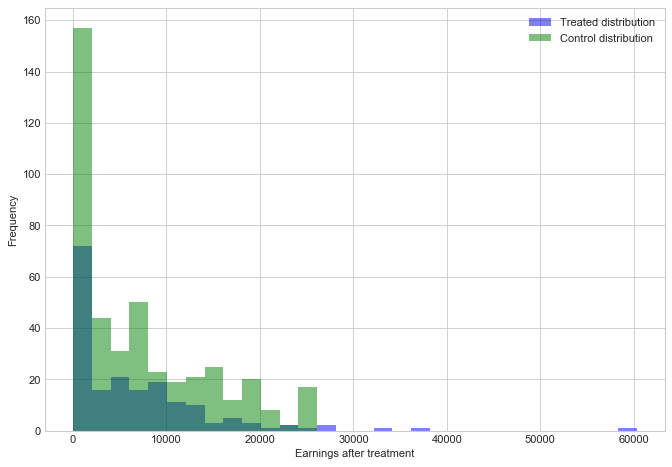

In [12]:
plot_output_distributions(treated, control)

In order to formalize what is shown in the plot we used the Kolmogorov–Smirnov test. This two-sample nonparametric test is used to compare two  continuous, one-dimensional distributions.

The null distribution of this statistic is calculated under the null hypothesis that the samples are drawn from the same distribution (in the two-sample variant used in our case).

If the K-S statistic is small or the p-value is high under certain margins, then we cannot reject the null hypothesis that the distributions of the two samples are the same.

In [13]:
s, p = stats.ks_2samp(treated['re78'],control['re78'])

print('\nThe K-S Test statistic for the two samples is {0} with a p-value of {1}\n'. format(s, p))


The K-S Test statistic for the two samples is 0.09860769860769869 with a p-value of 0.1527945228846811



TODO: what do we get from all this then? The control and the treatment samples can be considered taken from the same distributuon? So the the treatment doesn't really worked more for those who took it?

### 2. A closer look at the data
For each feature in the dataset, we compare its distribution in the treated group with its distribution in the control group, using plots and numbers

We will therefore get a closer look to the data by analyzing the distributions of the covariates of the two groups instead of only looking at the output. This will allow us to see if these covariates are distributed differently between both groups, which could be having an effect on the output variable that we are considering.

In the following graph we will compare the distributions of those variables in for treatment and control groups.

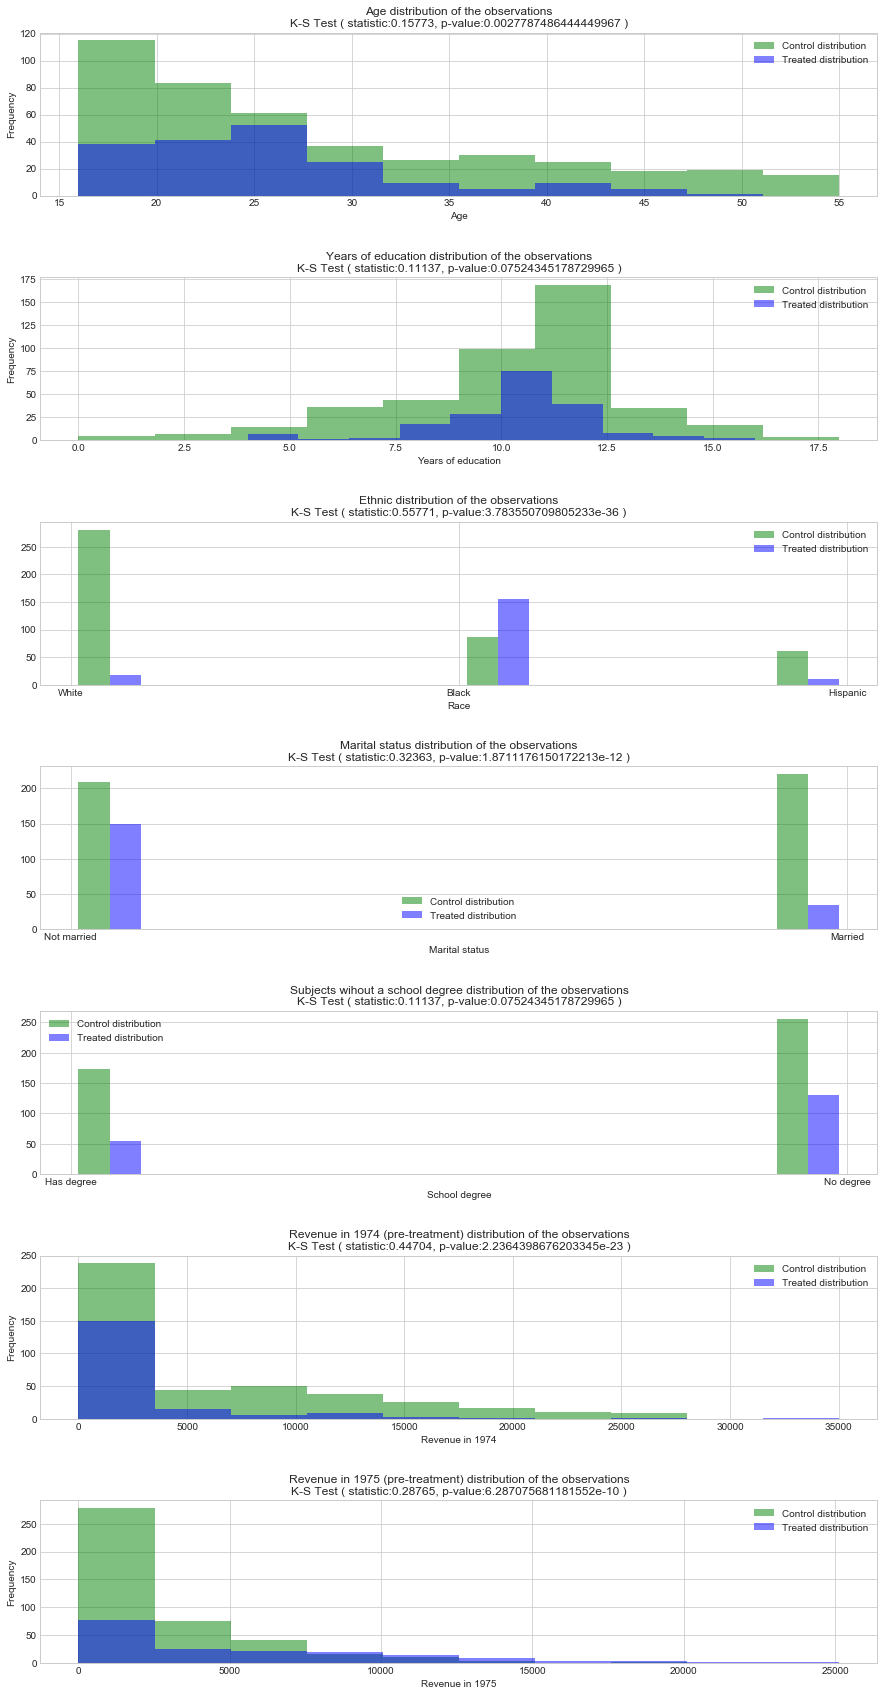

In [14]:
plot_feature_value_distributions(treated, control)

The K-S Test statistics presented in the plots are grouped in the following dataframe, showing for each covariate feature sample the behavior between the control and the treatment

In [15]:
variables = ['age', 'educ', 'race', 'married', 'nodegree', 're74', 're75']
ks_test_df = pd.DataFrame(columns=['Variable', 'K-S Test statistics', 'K-S Test p-value'])

for v in variables:
    # compute the K-S Test statistic for the v-th variable
    ks = stats.ks_2samp(treated[v], control[v])
    
    # append the results tot he dataframe
    s = pd.Series([v, ks[0], ks[1]],index=['Variable','K-S Test statistics', 'K-S Test p-value'])
    ks_test_df = ks_test_df.append(s, ignore_index=True)
    
ks_test_df

,Variable,K-S Test statistics,K-S Test p-value
0,age,0.157727,2.778749e-03
1,educ,0.111372,7.524345e-02
2,race,0.557714,3.783551e-36
3,married,0.323631,1.871118e-12
4,nodegree,0.111372,7.524345e-02
5,re74,0.447036,2.236440e-23
6,re75,0.287646,6.287076e-10


Since the p-values are as shown in the dataset we can reject the null hypothesis (the distributions of the two samples are the same) since the pvalue is below 1%. Thefore the two groups have a strongly different 'background' can't be directly compared as we did in the first task. 

### 3. A propensity score model
Use logistic regression to estimate propensity scores for all points in the dataset

As we have seen in the previous task, the two groups of control and treatment observations have very different covariate features samples and can't be directly compared between one and the other. We will need to balance the two groups and match obsrvations that can be considered similar in terms of those features.

To this matching, we will be using the `Propensity Score` method. We will assign to each observation a score that rappresent the probability for such observation to receive the treatment based on its pre-treatment features. This estimate will be drawn using the Logistic Regression method.

In [16]:
logistic = LogisticRegression()

The features we will use for the estimate are the following (pre-treatment:

In [17]:
features = ['age', 'educ', 'race', 'married', 'nodegree', 're74', 're75']

In [18]:
# The data matrix for the Logistic Regression
X = df[features]
X.head()

,age,educ,race,married,nodegree,re74,re75
id,,,,,,,
NSW1,37,11,1,1,1,0.0,0.0
NSW2,22,9,2,0,1,0.0,0.0
NSW3,30,12,1,0,0,0.0,0.0
NSW4,27,11,1,0,1,0.0,0.0
NSW5,33,8,1,0,1,0.0,0.0


The target of the Logistic Regression model will be the treatment feature of the dataframe

In [19]:
# The target vector for the Logistic Regression
y = df['treat']

In [20]:
# Train the model over X and Y
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
logistic.classes_

array([0, 1])

We assign this score to each observation drawn from the dataframe

In [22]:
pred = logistic.predict_proba(X)
df['propensity score'] = pred[:, 1]

df.head()

,treat,age,educ,married,nodegree,re74,re75,re78,race,propensity score
id,,,,,,,,,,
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,1,0.241581
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,2,0.705622
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,1,0.534734
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,1,0.504228
NSW5,1,33,8,0,1,0.0,0.0,289.7899,1,0.519416


### 4. Balancing the dataset via matching
Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group

In [23]:
B = build_graph(df)

The graph `B` is a not-connected graph containing a node for each observation (treatment or control). 

We will now build edges between each couple of nodes (v, u) such that v is from treatment group and u is from control group with a weight measured on the propensity score computed in the previous task.
In particular, we will try to minimize the distance between propensity_score(v) and propensity_score(u) as much as possible. The library used for this task implements already an algorithm that can draw the ***maximum*** weighted edges of a connected graph and therefore we will assign the following general weight to the couple of nodes(v, u):

    weight(v, u) = 1 - abs( propensity_score(v) - propensity_score(u) )

In [24]:
# Obtain a set from the graph for treatment and control nodes
t_set = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
c_set = set(B) - t_set

# For each couple of nodes of the sets, create a weighted edge
for t_node in t_set:
    for c_node in c_set:
        B.add_edge(t_node, c_node, weight= (1 - abs(B.node[t_node]['score'] - B.node[c_node]['score'])) )

The result is a connected graph with all the weights computed as described

In [25]:
nx.is_connected(B)

True

Compute the maximum of the different weights for the perfect matching on the scores

In [26]:
match = nx.bipartite.maximum_matching(B)

We can now have a new dataframe containing a subset of observations that have the highest matching according to the propensity score. This dataframe will contain the same amount of control and treatment samples

In [27]:
matched_df = pd.DataFrame()

for e in match.items():
    s = df.loc[e[0], 'treat':'race']
    s.set_value('id', e[0])
    
    matched_df = matched_df.append( s, ignore_index=True)
    
matched_df.head()

,age,educ,id,married,nodegree,race,re74,re75,re78,treat
0,29.0,8.0,NSW62,0.0,1.0,1.0,0.000,0.0000,1923.9380,1.0
1,22.0,16.0,NSW9,0.0,0.0,1.0,0.000,0.0000,2164.0220,1.0
2,29.0,4.0,NSW65,0.0,1.0,1.0,0.000,0.0000,762.9146,1.0
3,22.0,11.0,NSW60,0.0,1.0,0.0,0.000,0.0000,1048.4320,1.0
4,21.0,12.0,NSW116,0.0,0.0,0.0,3670.872,334.0494,12558.0200,1.0


In [28]:
matched_df_treated = matched_df[matched_df["treat"] == 1]
matched_df_control = matched_df[matched_df["treat"] == 0]

As we said just before, these two groups contain the same amount of samples:

In [29]:
print('Number of treatment observations {}'.format( len(matched_df_treated)))
print('Number of control observations {}'.format( len(matched_df_control)))

Number of treatment observations 185
Number of control observations 185


We can therefore do the same analysis we did in the beginning of the question. We will compare the distribution of the output variable (re78) for both the control and treatment groups. We will do, as well, an analysis on the different covariates features of those groups.

This analysis will be done on the matched dataframe of observations we just computed

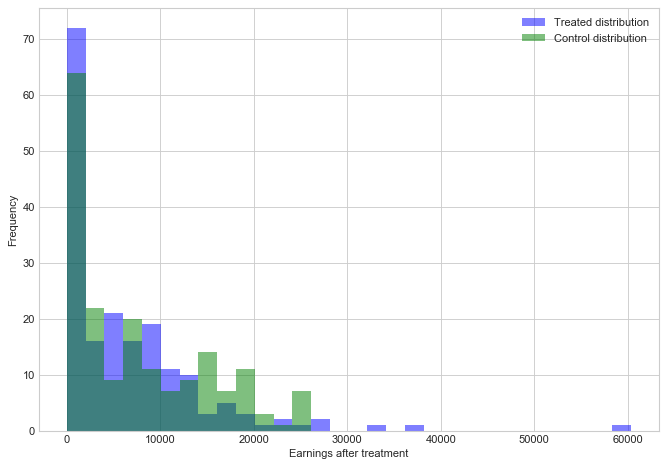

In [30]:
plot_output_distributions(matched_df_treated, matched_df_control)

As did previously, we can use the K-S Test to compare the distributions

In [31]:
s, p = stats.ks_2samp(matched_df_treated['re78'],matched_df_control['re78'])

print('\nThe K-S Test statistic for the two samples (matched) is {0} with a p-value of {1}\n'. format(s, p))


The K-S Test statistic for the two samples (matched) is 0.1351351351351352 with a p-value of 0.0621483304502747



And compare it with the previous result obtained to understand how the matching changed the comparison

In [32]:
s, p = stats.ks_2samp(treated['re78'],treated['re78'])

print('\nThe K-S Test statistic for the two samples (original) is {0} with a p-value of {1}\n'. format(s, p))


The K-S Test statistic for the two samples (original) is 0.0 with a p-value of 1.0



The covariates features for those two matched group can now be compared on the following plots

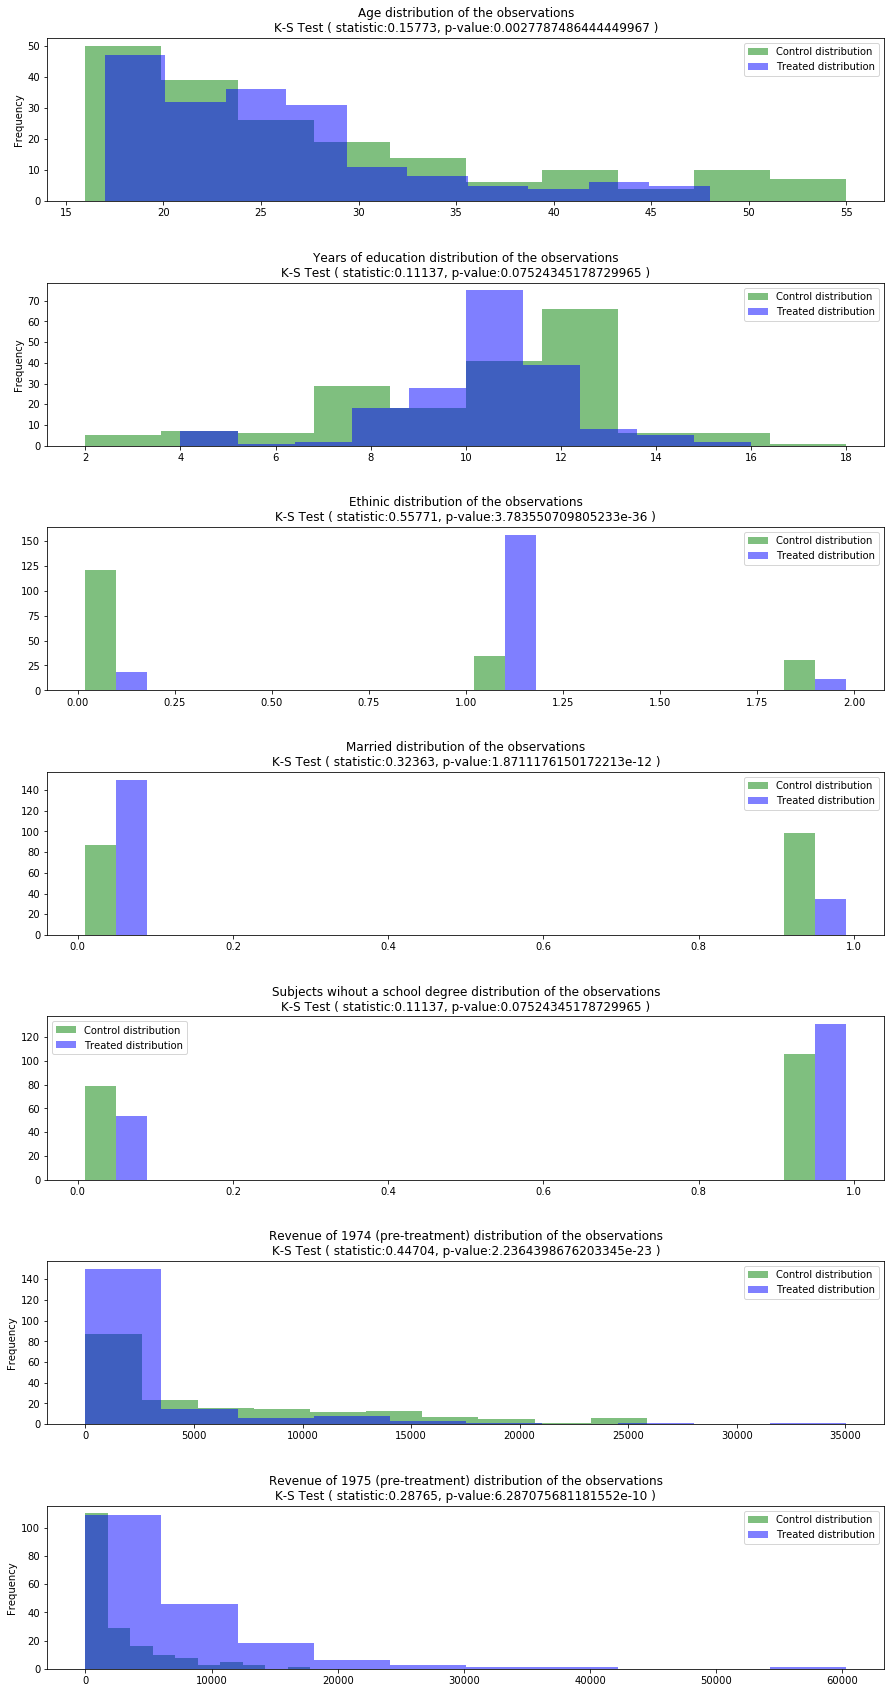

In [33]:
plot_feature_value_distributions(matched_df_treated, matched_df_control)

### 5. Balancing the groups further
Improve the matching by explicitly making sure that you match only subjects that have the same value for the problematic feature

As a result from the previous task we have obtained two groups that were matched according to the propensity score computed. But as shown in the plots of the covariates features distributions, those have not been matched as good as the output variable. Therefore we can improve our matching considering thos eproblematic features and match them manually. We will consider the two most problematic distributions: race and married.

TODO: According to the plots of task 4, should we do the manual matching on re74 too? The K-S Test suggests that ... right?

In [34]:
B_improved = build_graph(df)

In [35]:
t_set = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
c_set = set(B) - t_set

for t_node in t_set:
    for c_node in c_set:
        
        if (B_improved.node[t_node]['race'] == B_improved.node[c_node]['race']) and (B_improved.node[t_node]['married'] == B_improved.node[c_node]['married']):
                
            B_improved.add_edge(t_node, c_node, 
                   weight= (1 - abs(B_improved.node[t_node]['score'] - B_improved.node[c_node]['score'])))

The new graph contains nodes with perfectly balanced features for those problematic distributions. We can now match the weights as did before and se the resulting samples

In [36]:
match_improved = nx.bipartite.maximum_matching(B_improved)

In [37]:
matched_df = pd.DataFrame()

for e in match_improved.items():
    s = df.loc[e[0], 'treat':'race']
    s.set_value('id', e[0])
    
    matched_df = matched_df.append( s, ignore_index=True)
    
matched_df.head()

,age,educ,id,married,nodegree,race,re74,re75,re78,treat
0,24.0,11.0,NSW135,1.0,1.0,1.0,824.3886,1666.113,4032.7080,1.0
1,29.0,4.0,NSW65,0.0,1.0,1.0,0.0000,0.000,762.9146,1.0
2,40.0,11.0,NSW79,0.0,1.0,1.0,0.0000,0.000,23005.6000,1.0
3,27.0,10.0,NSW14,1.0,1.0,1.0,0.0000,0.000,18739.9300,1.0
4,31.0,12.0,NSW145,0.0,0.0,0.0,0.0000,2611.218,2484.5490,1.0


In [38]:
matched_df_treated = matched_df[matched_df["treat"] == 1]
matched_df_control = matched_df[matched_df["treat"] == 0]

Replotting the different features we can appreciate an even better balance after this rematch of the nodes between the two groups

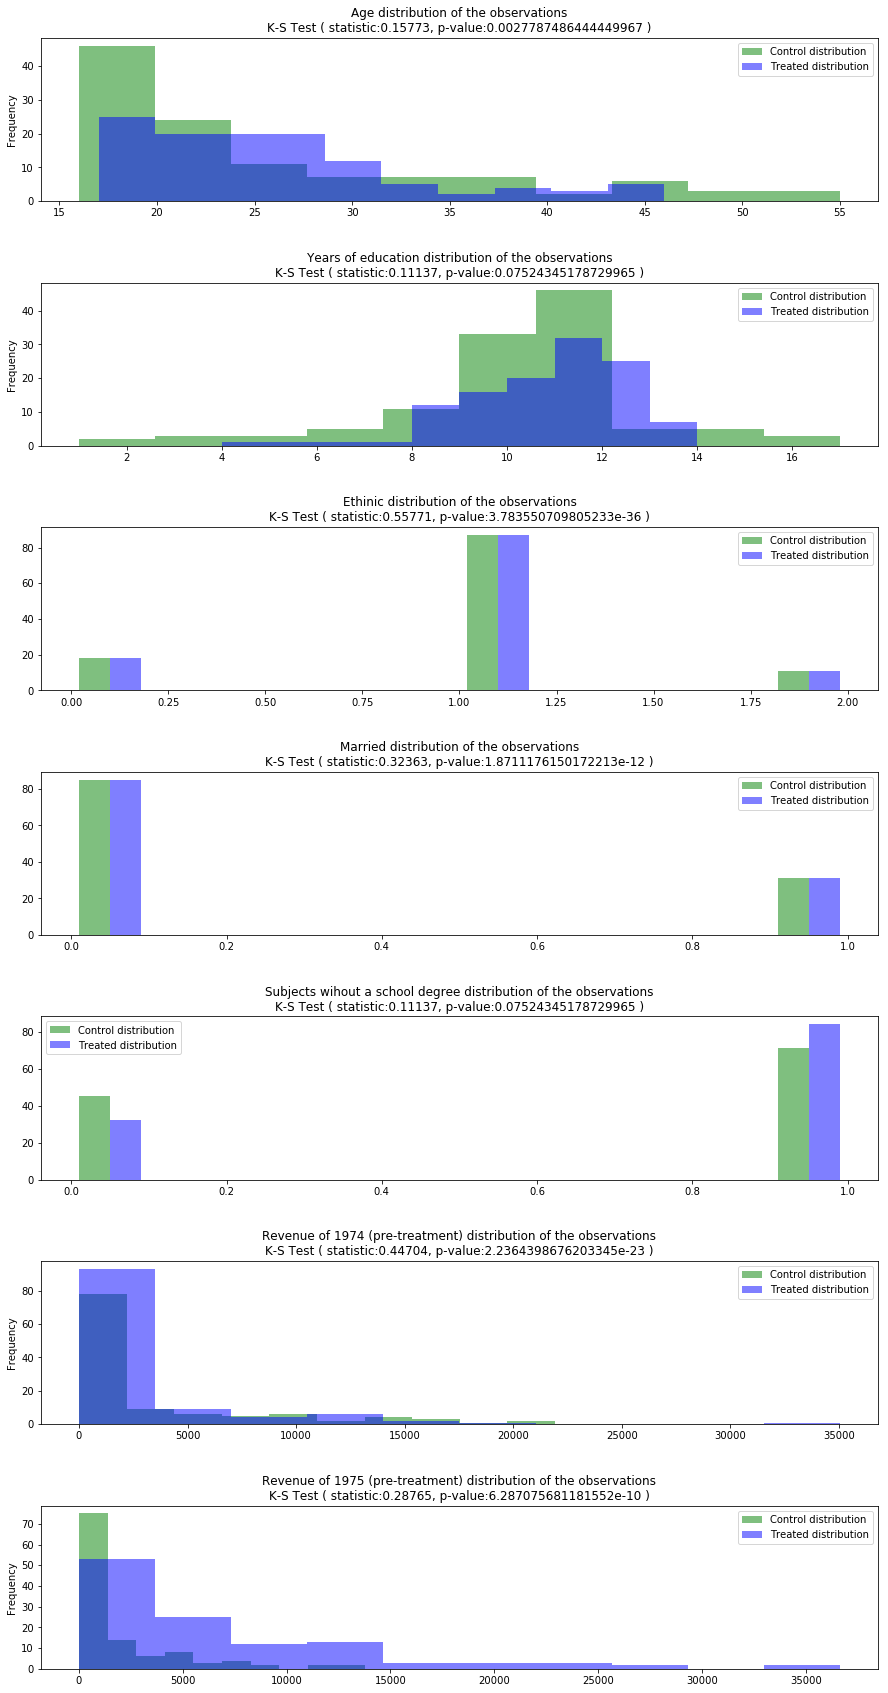

In [39]:
plot_feature_value_distributions(matched_df_treated, matched_df_control)

### 6. A less naive analysis
Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program?

In conclusion, the output variable after all those matches can be compared between control and treatment group

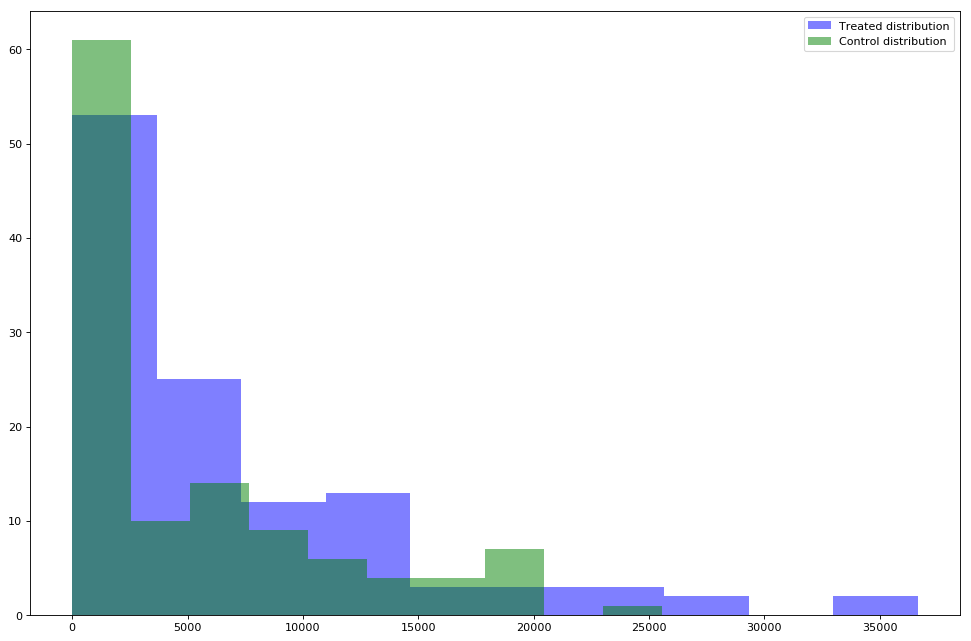

In [40]:
plot_output_distributions(matched_df_treated, matched_df_control)

In [41]:
s, p = stats.ks_2samp(matched_df_treated['re78'],matched_df_control['re78'])

print('\nThe K-S Test statistic for the two samples is {0} with a p-value of {1}\n'. format(s, p))


The K-S Test statistic for the two samples is 0.13793103448275862 with a p-value of 0.203231740327001



We can finally compare the improvements did during analysys from the naive approach to the well-matched case. In the following two plots, the output variable of the two groups are shown in the different stages (initial, final)

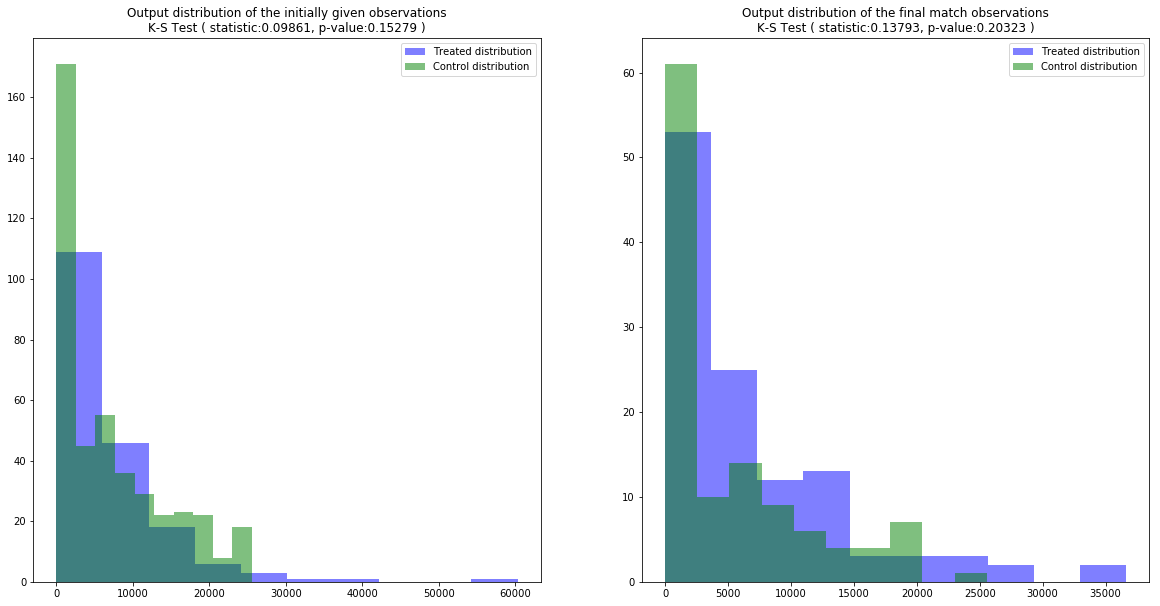

In [42]:
plot_plot_output_distributions_compare_results(treated, control, matched_df_treated, matched_df_control)

 # 2 Applied ML

### 2.1 Load the 20newsgroup dataset, get textual features and split data

We start by loading the dataset. The data is loaded in an object type `sklearn.utils.Bunch`, which is a dictionary-like object. The interesting attributes (or *keys* of this object) are:
* `data`: The data to learn. As shown, there are 18846 samples in the entire dataset that we will split into training, test and validation.
* `target`: The classification labels.
* `target_names`: The 20 different labels.

In [3]:
newsgroups = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH),
    subset='all')

In [4]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [5]:
len(newsgroups.data)

18846

We now use `sklearn` and compute the textual features with `TfidfVectorizer`. We only compute 6000 features so that it doesn't take so long to train the model afterwards.

In [6]:
vectorizer = TfidfVectorizer(max_features=6000)
vectors = vectorizer.fit_transform(newsgroups.data)

Next, we split into training, test and validation sets. The size of the test and validation sets will be of 10% of the total each, and we will train on the remaining 80%.

To do it we first generate a permutation of the indices of the data entries. Then we keep the first 10% for validation, and out of the remaining 90% we use 10% for test and the rest for training. We use these indices to split both the features `x` and the classification labels `y`.

In [9]:
# We define 'x' (textual features) and 'y' (classification labels)
x = vectors
y = newsgroups.target

# We set a random seed for reproducibility
np.random.seed(512)
ratio = .1


x_all, x_val, y_all, y_val = train_test_split(x, y, test_size=ratio, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=ratio, random_state=42)

### 2.2 Train a random forest and assess the model

We will now train a random forest on the training set.

We need to choose the parameters `n_estimators` and `max_depth`, which we will do by using grid-search.

For this we define two auxiliary functions. The first function (`grid_search`) iterates over the vectors of values for the two parameters, and calls the function `r_forest_accuracy` to compute the accuracy of the classification for each pair of parameters. We chose the ranges of the parameters so that we could try several combinations of them, but stopped at the point where the computation time was too long.

It is worth to emphasize that we will train the random forest over the training set, and then compute the accuracy over the test set. We will then keep the pair of parameters that achieved a highest accuracy for the test set.

Lastly, we will assess our model by using the samples in the validation test.

In [13]:
def grid_search(x_train, y_train, x_test, y_test, n_estimators_s, max_depth_s):
    """Algorithm for grid search."""
    accuracies = np.zeros((len(n_estimators_s), len(max_depth_s)))

    for i in range(len(n_estimators_s)):
        for j in range(len(max_depth_s)):
            accuracies[i][j] = r_forest_accuracy(x_train, y_train, x_test, y_test,
                n_estimators_s[i], max_depth_s[j])
    return accuracies

In [14]:
feature_names[100:120]

In [ ]:
rs = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.1)
rs.get_n_splits(newsgroups)

In [ ]:
def r_forest_accuracy(x_train, y_train, x_test, y_test, n_estimators, max_depth):
    # Build the random forest classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=0,
        n_jobs=-1)
    
    # Fit the model to the training data 
    clf.fit(x_train, y_train)
    
    # Obtain predictions for test set
    y_pred = clf.predict(x_test)
    
    # Calculate accuracy
    return np.sum(y_test == y_pred)/len(y_test)

In [17]:
n_estimators_s = np.arange(60, 240, 30)
max_depth_s = np.arange(30, 240, 30)

accuracies = grid_search(x_train, y_train,
    x_test, y_test,
    n_estimators_s, max_depth_s)

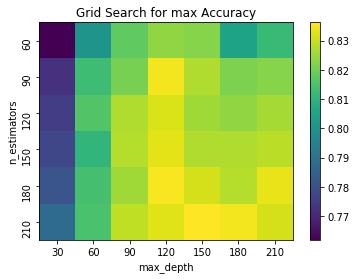

In [18]:
plt.imshow(accuracies)
plt.colorbar()
plt.title('Grid Search for max Accuracy')
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
tick_marks_x = np.arange(len(max_depth_s))
tick_marks_y = np.arange(len(n_estimators_s))
plt.yticks(tick_marks_y, n_estimators_s, rotation=90)
plt.xticks(tick_marks_x, max_depth_s)
plt.show()

In [ ]:
for train_index, test_index in rs.split(newsgroups):

We can see that the pair of parameters that gives us the best result is `n_estimators=210` and `max_depth=150`. The accuracy obtained with these parameters is 0.83618.

We will now try to improve the accuracy by focusing the grid search on the parameters range that achieve highest accuracies. 

In [23]:
n_estimators_s = np.arange(150, 270, 30)
max_depth_s = np.arange(120, 240, 30)

accuracies_improved = grid_search(x_train, y_train,
    x_test, y_test,
    n_estimators_s, max_depth_s)

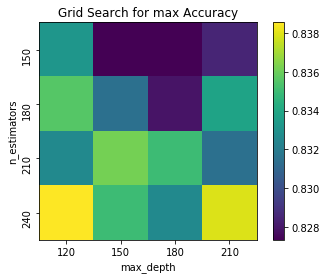

In [24]:
plt.imshow(accuracies_improved)
plt.colorbar()
plt.title('Grid Search for max Accuracy')
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
tick_marks_x = np.arange(len(max_depth_s))
tick_marks_y = np.arange(len(n_estimators_s))
plt.yticks(tick_marks_y, n_estimators_s, rotation=90)
plt.xticks(tick_marks_x, max_depth_s)
plt.show()

The best result is achieved with `n_estimators=240` and `max_depth=120`. The accuracy obtained with these parameters is 0.838538.

In [27]:
clf = RandomForestClassifier(
    n_estimators=240,
    max_depth=120,
    random_state=0,
    n_jobs=-1)
    
# Fit the model to the training data 
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=120, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=240, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Now we will obtain the predictions for the validation set. We will compare these predictions with the classification labels, and build the confusion matrix for the chosen model. 

The function for plotting the confusion matrix was found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [28]:
# Compute predictions for validation set
y_pred = clf.predict(x_val)

# Build confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    #print('Confusion matrix, without normalization')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

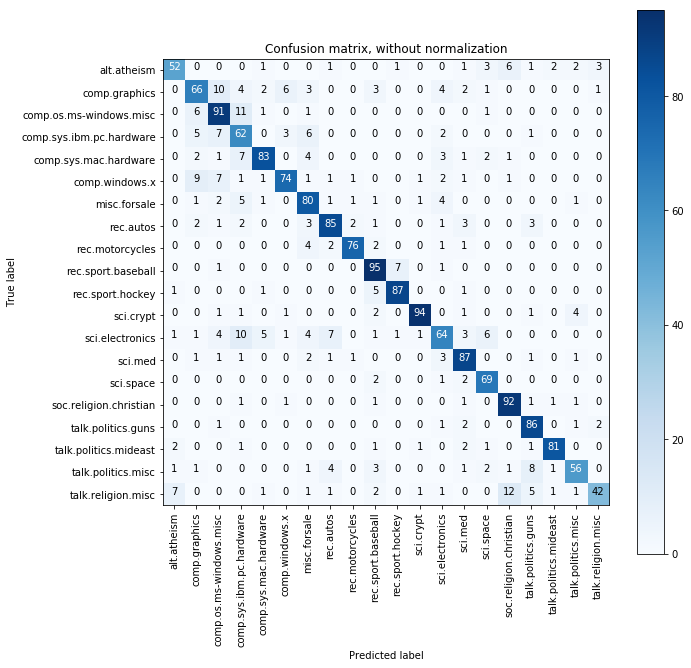

In [30]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names, title='Confusion matrix, without normalization')

We can see from the confusion matrix that overall the classification works properly, since the elements in the diagonal have higher values than the other elements. However, it is noticeable that some of the news labelled as `talk.religion.misc` have been mislabelled as `soc.religion.christian`.  

Lastly, we will inspect the `feature_importances_` attribute of the random forest.

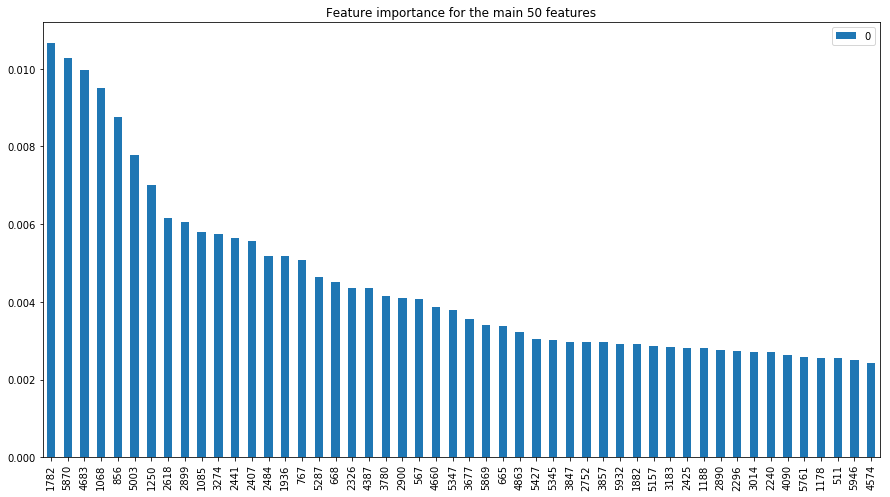

In [31]:
#Create dataframe with features ordered according to importance
feature_importances_df = pd.DataFrame(clf.feature_importances_).sort_values(by=0, ascending=False)

# Plot 50 most important features
feature_importances_df.head(50).plot(y=0, kind='bar', figsize=(15,8),
    title='Feature importance for the main 50 features')

In the previous plot we can see that the feature importance is higher for the first 25 features aproximately, and then slowly decreases for the remaining ones (they have been ommitted from the plot for more clarity, since it did not give important information to the reader). This suggests that if we needed to reduce the number of features, we could have kept only the first 25 ones, or even only the first 16.